# Imports

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
2
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics

In [3]:
import numpy as np
import os
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

# Parameters

In [4]:
want_to_train = True        # Set this parameter to False if you want to load the model from the folder
want_to_generate = True     # Set this parameter to False if you want to load the generation from the folder
calculate_metrics = True    # Set this parameter to False if you don't want to calculate any metric

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 32,
    'feature_dim': 7,
    'seq_len': 150,
    'val_split': 0.1,
    'batch_size': 32,
    'epochs': 5,
    'beta': 1,
    'lr': 0.001,
    'dropout_rate': 0.2,
    'num_samples': 100
}

# Data

## Import

In [7]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 150)

## Scaling

In [8]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([45211, 7, 150])

# Modelling

In [9]:
model = get_model(params)

In [10]:
train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

In [11]:
loss_history = VAELossHistory()

trainer = Trainer(
    max_epochs=params.get('epochs', 10),
    log_every_n_steps=10,
    devices="auto",
    accelerator="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[loss_history]
)

trainer.fit(model, train_loader, val_loader)

for metric_name, metric_value in trainer.callback_metrics.items():
    print(f"{metric_name}: {metric_value}")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


val_total_loss: 12.232850074768066
val_reconstruction_loss: 8.374235153198242
val_kl_loss: 3.858614921569824
train_total_loss: 10.906333923339844
train_reconstruction_loss: 7.015345096588135
train_kl_loss: 3.890979051589966


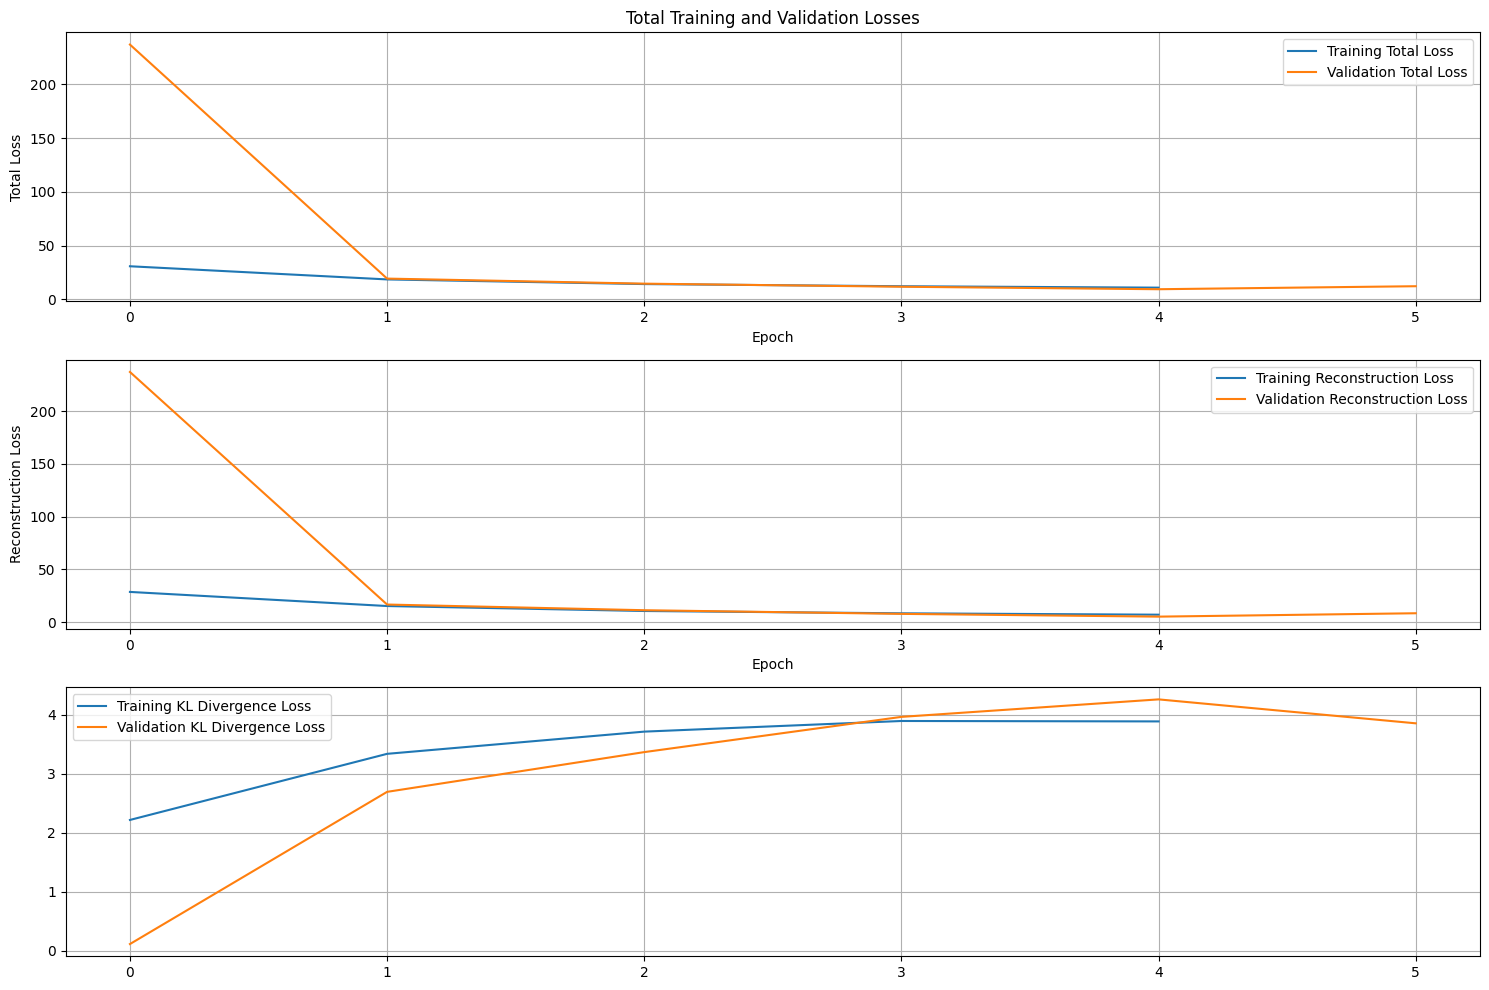

In [12]:
loss_history.plot_all_losses()

## Saving

In [13]:
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

Parameters already exist for experiment: ../experiments/experiment_1


In [14]:
# Define full paths for saving

generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_all_generated_data.png')
static_some_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_some_generated_data.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
sampled_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_sampled_latent_representations.npy')
labels_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_labels_latent_representations.npy')
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

In [15]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=trainer.callback_metrics)
    

Metrics added to experiment with ID 1 in ../experiments/experiments.json.


In [16]:
torch.save(model.state_dict(), model_save_path)

## Generate

In [17]:
if want_to_generate:
    # Generate the orbits
    generation = model.sample(params['num_samples'])
    generation = scaler.inverse_transform(generation)
    # np.save(generated_data_path, generation)
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

torch.Size([100, 7, 150])

# Analysis of Generation

## Visualization

In [19]:
if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:].detach().numpy()
    generation.shape
else:
    no_time_generation = generation.cpu().numpy()

no_time_generation.shape

(100, 6, 150)

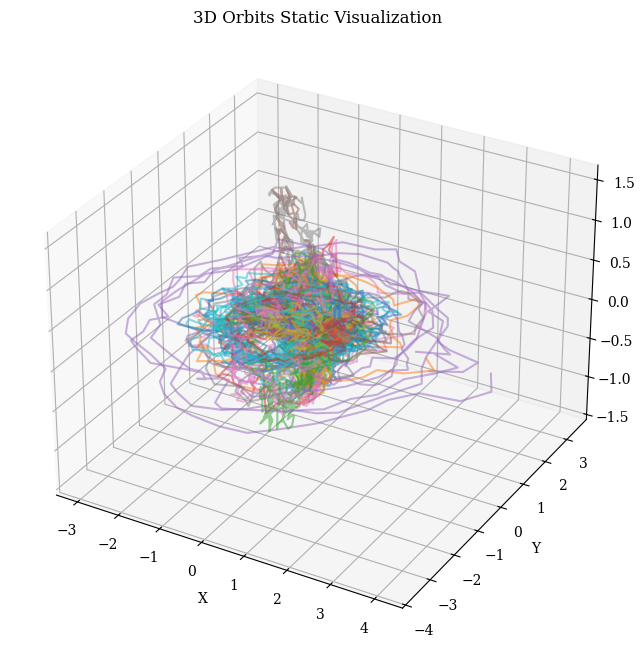

In [20]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

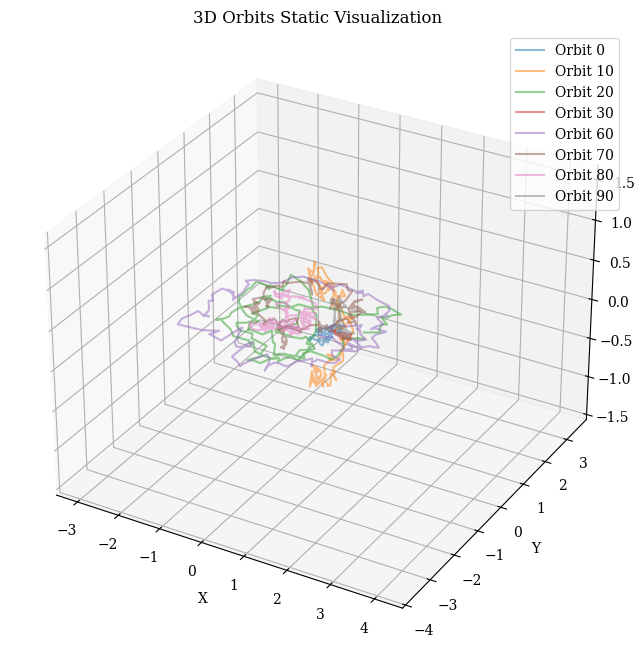

In [21]:
visualize_static_orbits(data= no_time_generation, orbit_indices=[0,10,20,30,60,70,80,90], save_path=static_some_orbit_path)

In [22]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_1/images/exp1_generated_orbits.html


## Coverage

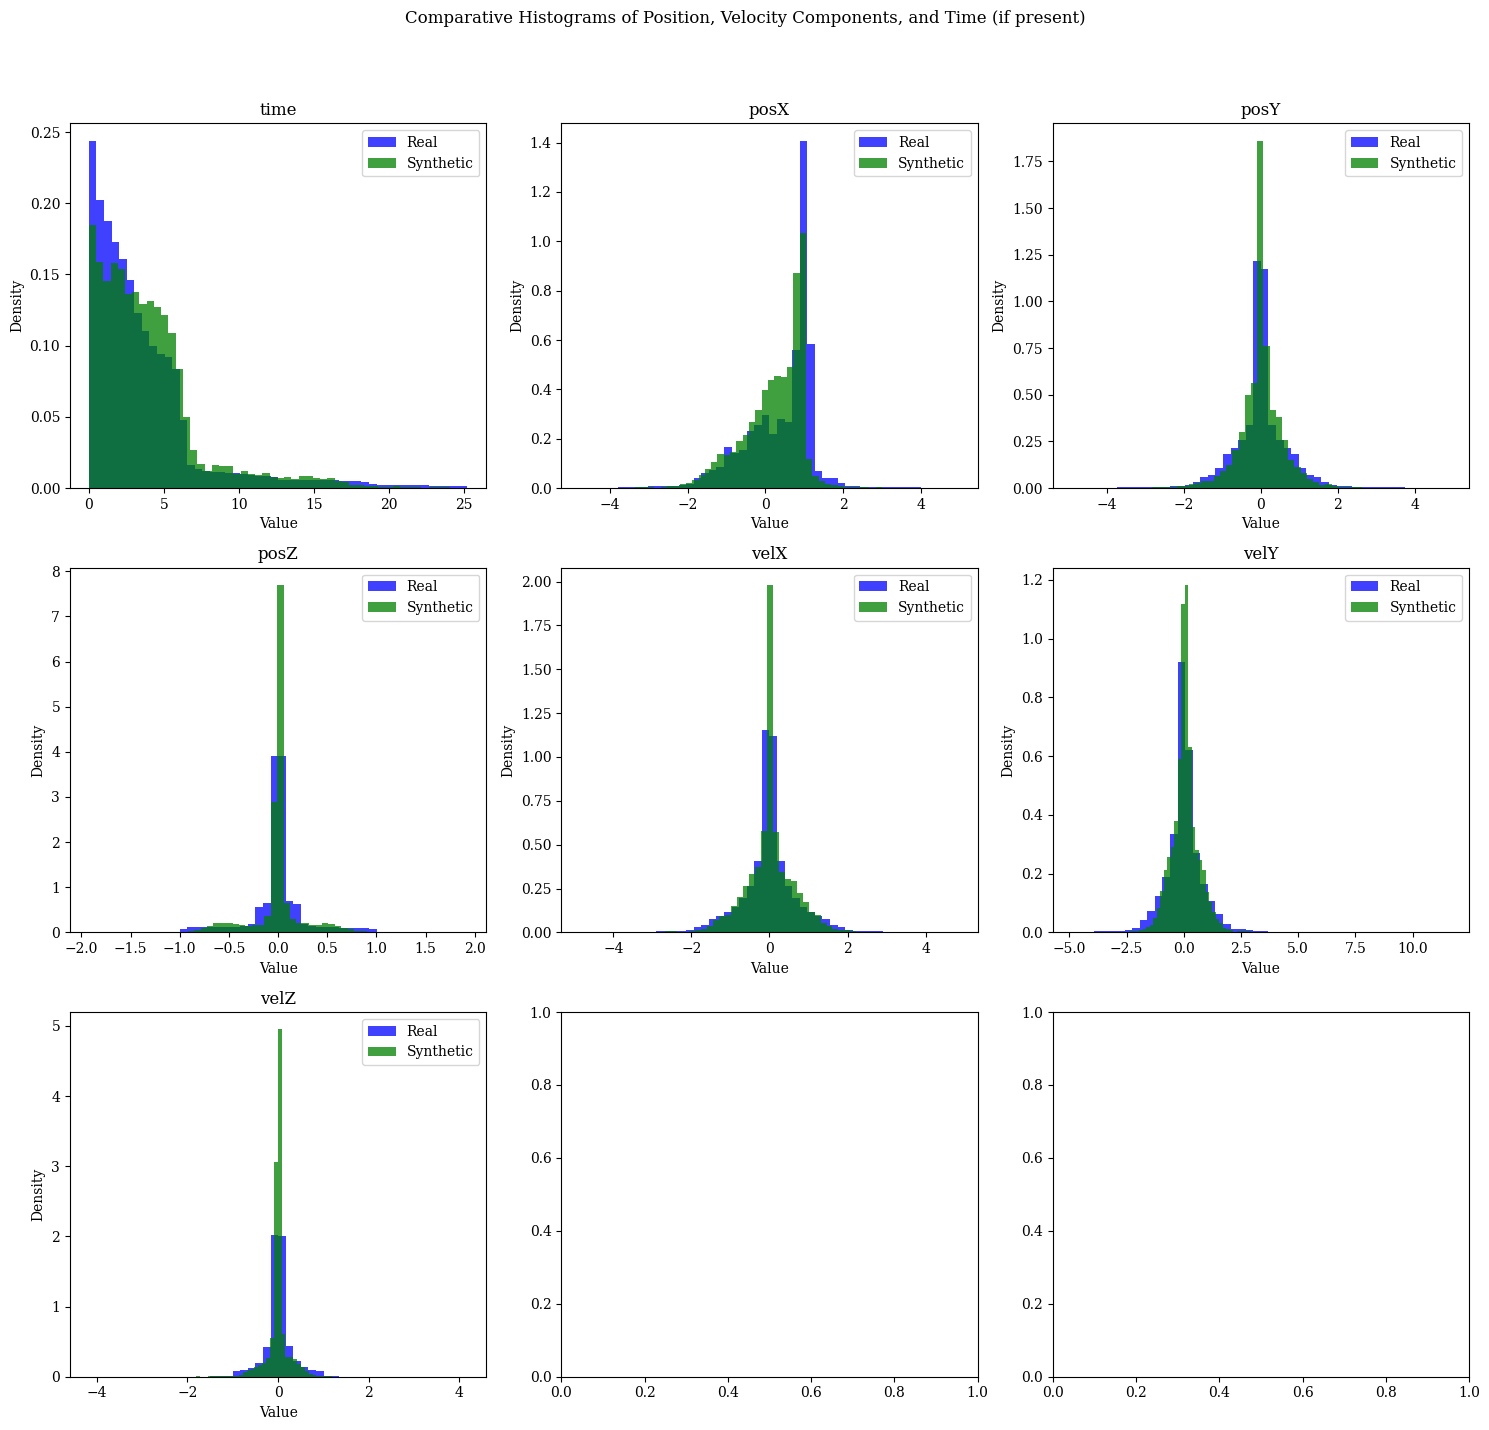

In [24]:
plot_histograms_comparison(data1=data, data2=generation.detach().numpy(), label1='Real', label2='Synthetic', normalize=True)

## Pheasibility

Cumulative position error for selected orbits: 5997.838239557175
Average position error per time step: 40.25394791649111


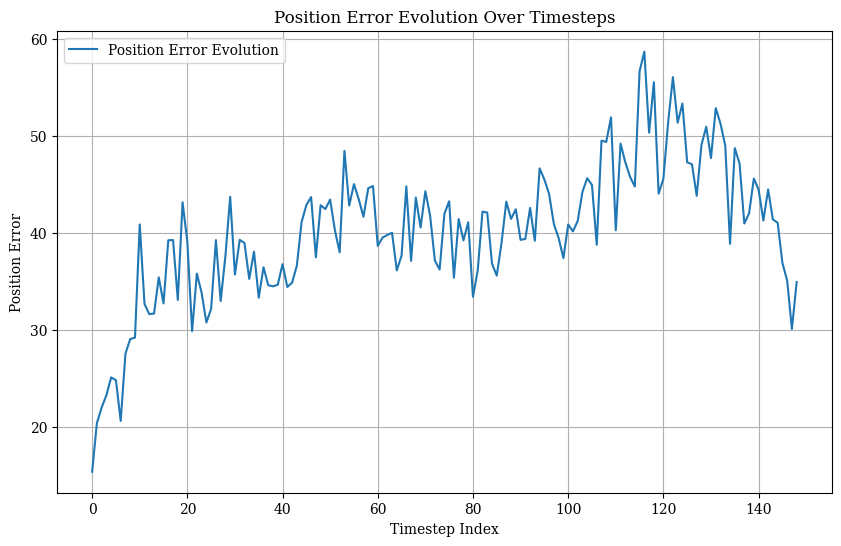

Cumulative velocity error for selected orbits: 8723.0227910425
Average velocity error per time step: 58.543777121090606


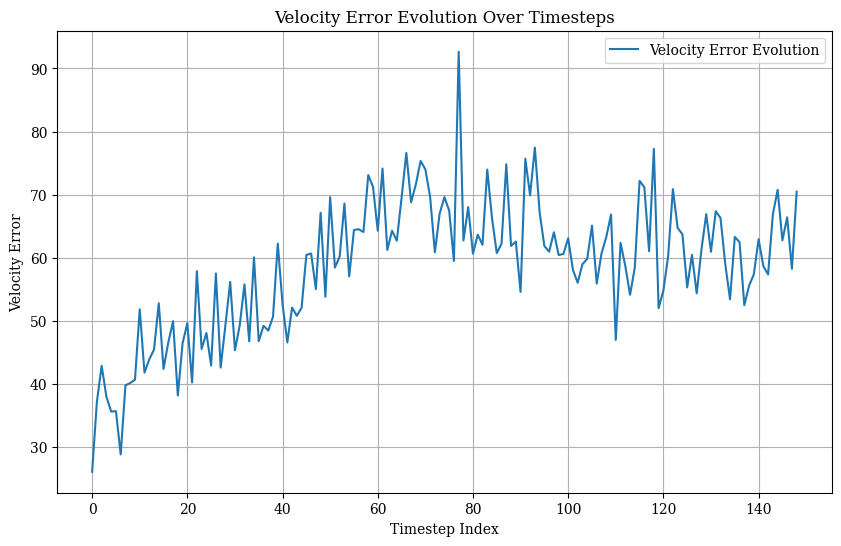

Cumulative energy error for selected orbits: 17080.736328125
Average energy error per time step: 114.63581085205078


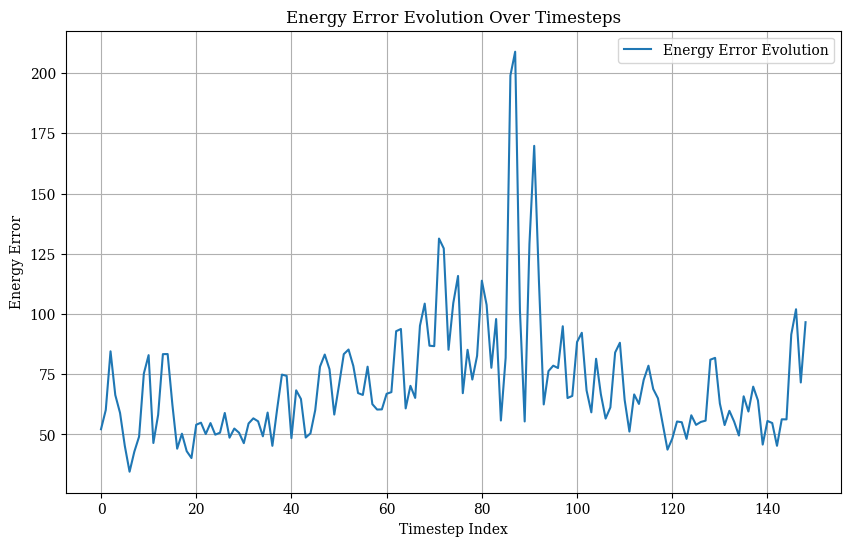

Metrics added to experiment with ID 1 in ../experiments/experiments.json.


In [27]:
if calculate_metrics:
    reordered_orbits, order_metrics = reorder_orbits(generation.detach().numpy())
    errors = calculate_errors(reordered_orbits,EM_MU)
    add_experiment_metrics(experiments_folder, params=params, metrics={**errors, **order_metrics})